In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

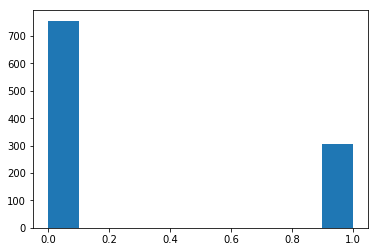

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

In [3]:
fps = rdkitDescriptors.batch_compute_rdkit_fingerprints(df['SMILES'])
len(fps[0])

2048

In [4]:
from dimreducer import DeepAutoEncoder as DAE

In [5]:
dims =[2048,1028,128]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, norm_feature=False, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1063/1063 [==============================] - 1s 591us/step - loss: 0.0821
Epoch 2/50
1063/1063 [==============================] - 0s 303us/step - loss: 0.0716
Epoch 3/50
1063/1063 [==============================] - 0s 297us/step - loss: 0.0659
Epoch 4/50
1063/1063 [==============================] - 0s 309us/step - loss: 0.0598
Epoch 5/50
1063/1063 [==============================] - 0s 304us/step - loss: 0.0547
Epoch 6/50
1063/1063 [==============================] - 0s 299us/step - loss: 0.0501
Epoch 7/50
1063/1063 [==============================] - 0s 298us/step - loss: 0.0463
Epoch 8/50
1063/1063 [==============================] - 0s 297us/step - loss: 0.0426
Epoch 9/50
1063/1063 [==============================] - 0s 296us/step - loss: 0.0392
Epoch 10/50
1063/1063 [==============================] - 0s 293us/step - loss: 0.0366
Epoch 11/50
1063/1063 [======

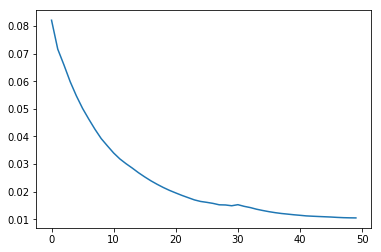

In [6]:
plt.plot(history.history['loss'])

### Use update_interval = 50

In [7]:
autoencoder_dims = [2048,1028,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50, clustering_tol=1e-3)
dce.build_model(norm=False, act='relu')

In [8]:
dce.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 2048)         0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 1028)         2106372     input[0][0]                      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 128)          131712      encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 (Dense)               (None, 1028)         132612      embedding_layer[0][0]            
__________________________________________________________________________________________________
clustering

In [9]:
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model(norm=False)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')


Start to train model with cluster weight: 0.1
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to tra

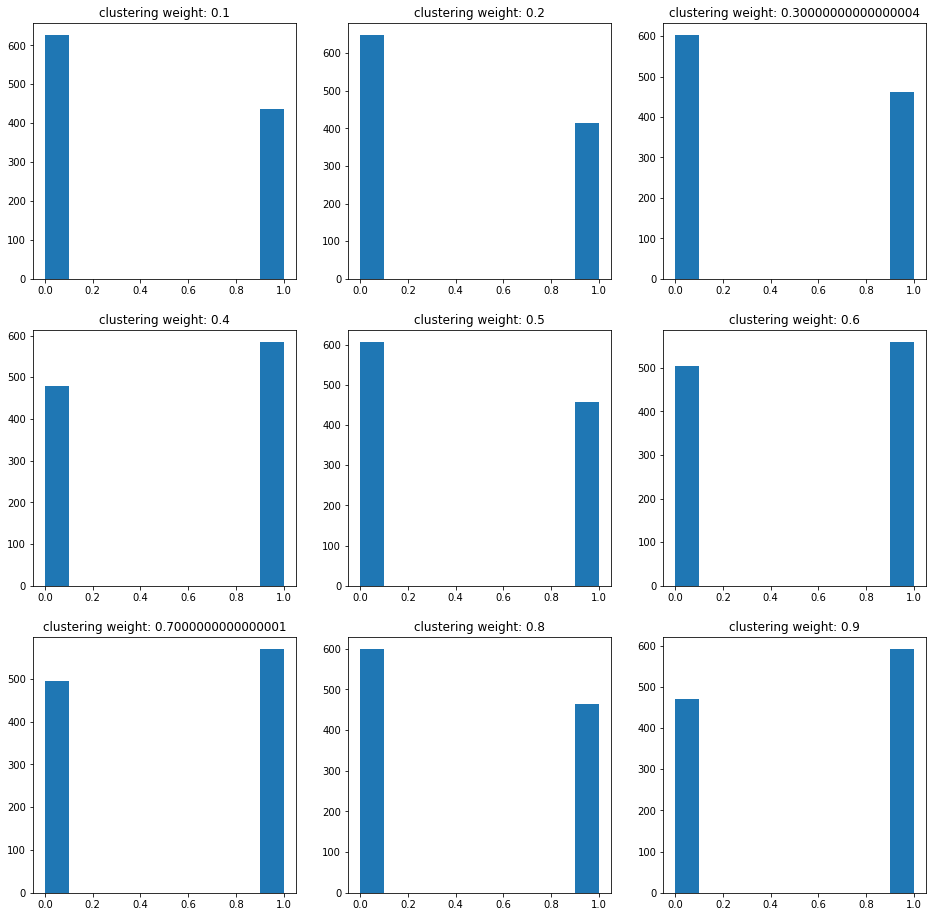

In [10]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].hist(results[i][0])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

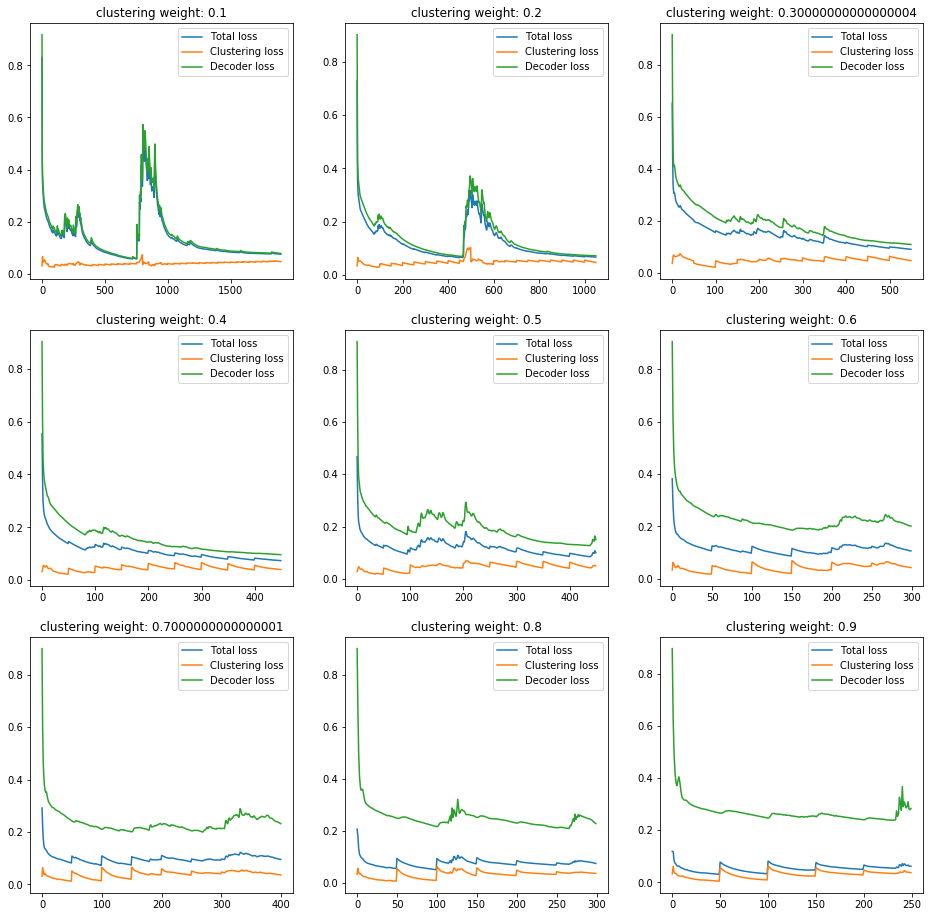

In [11]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))


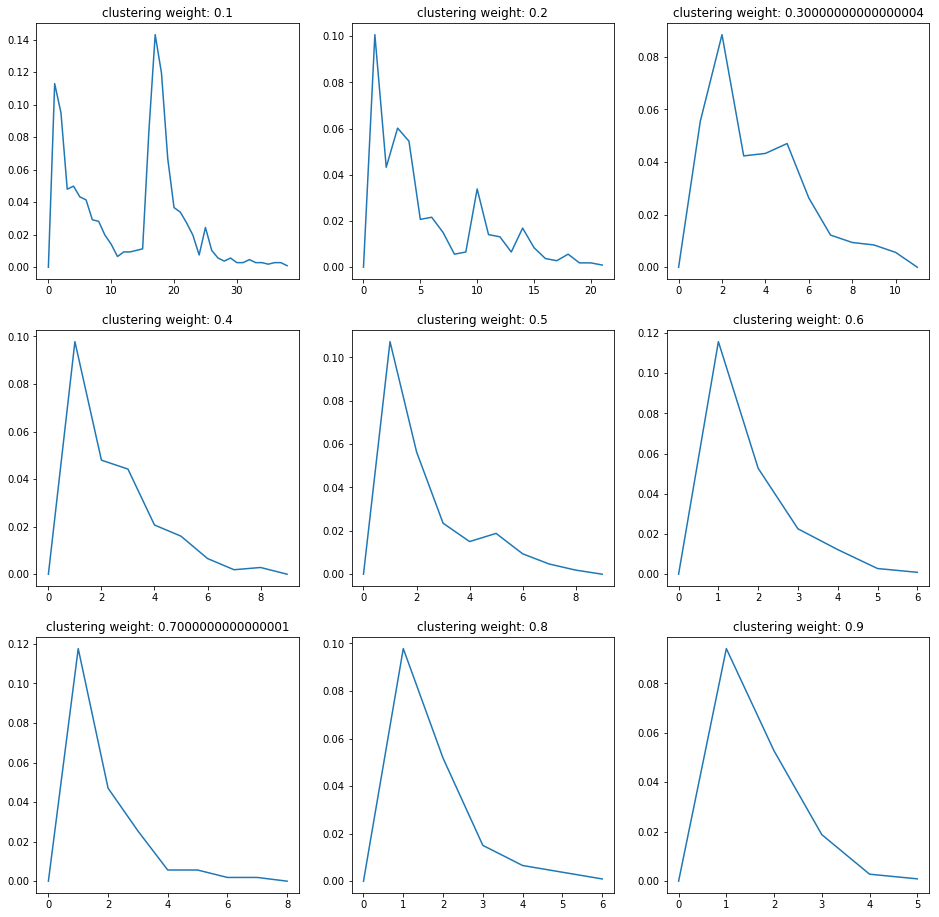

In [12]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][2])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

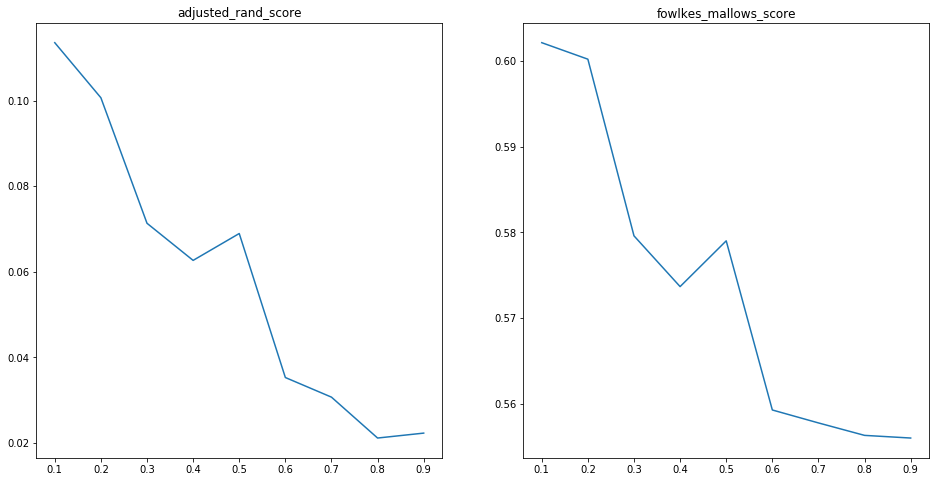

In [13]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')

In [14]:
result_i

[array([0, 1, 0, ..., 0, 0, 1]),
 array([[0.11921427, 0.1179733 , 0.08276008, 0.07314502, 0.06963401,
         0.06342632, 0.06212488, 0.06286793, 0.06012184, 0.05650104,
         0.05481762, 0.05419395, 0.05215913, 0.04992157, 0.04903474,
         0.04859737, 0.04733144, 0.04571347, 0.04468673, 0.04425501,
         0.04337581, 0.0420537 , 0.04129339, 0.04086801, 0.04009466,
         0.03910438, 0.03864293, 0.03837205, 0.03765689, 0.03695587,
         0.03663764, 0.03667232, 0.03673545, 0.03655188, 0.0361871 ,
         0.0356623 , 0.0351355 , 0.0348001 , 0.03460344, 0.0342916 ,
         0.03381219, 0.03337909, 0.03305569, 0.03271237, 0.03236882,
         0.03206313, 0.03178203, 0.03148798, 0.03120078, 0.03093771,
         0.07790453, 0.07469573, 0.07264306, 0.06949299, 0.06725499,
         0.06574325, 0.06343395, 0.06190317, 0.0602923 , 0.05861894,
         0.05750745, 0.05601525, 0.05480627, 0.05360587, 0.05245868,
         0.05149295, 0.05050312, 0.04950358, 0.04865775, 0.04777544,
 

### Use update_interval = 25

In [15]:
autoencoder_dims = [2048,512,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')


Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

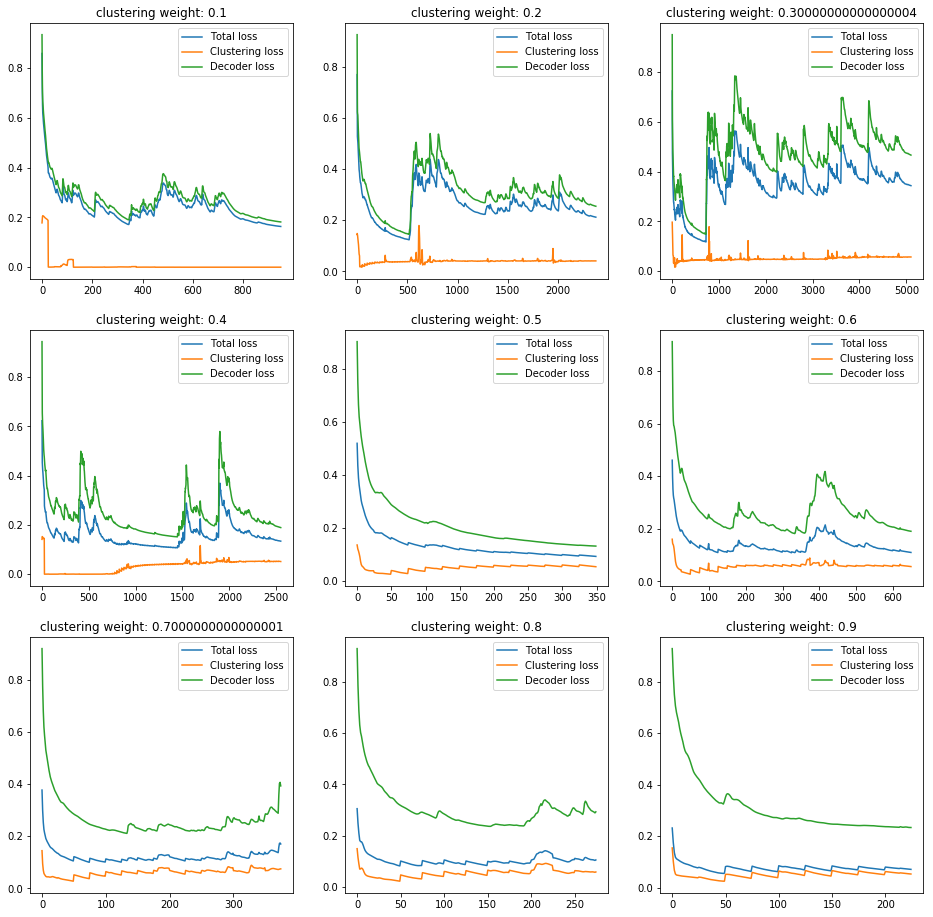

In [16]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

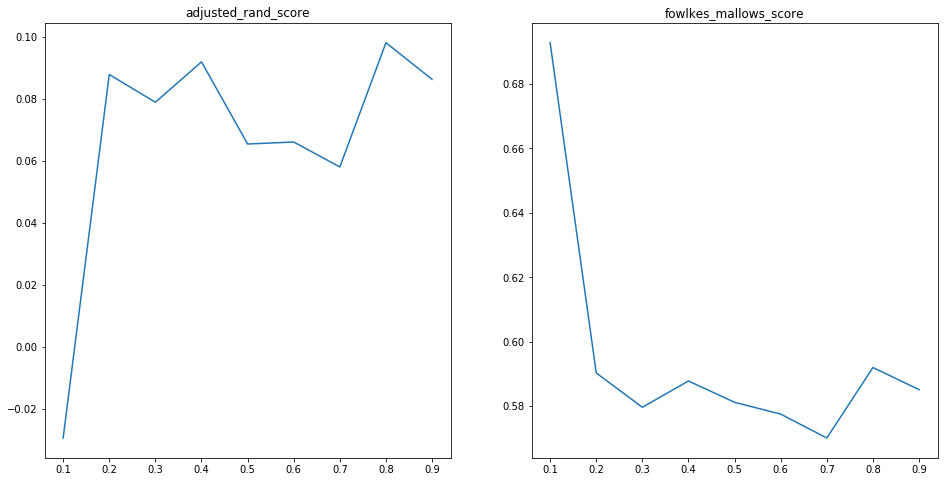

In [17]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')

### Use update_interval = 10

In [18]:
autoencoder_dims = [2048,512,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=10)
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

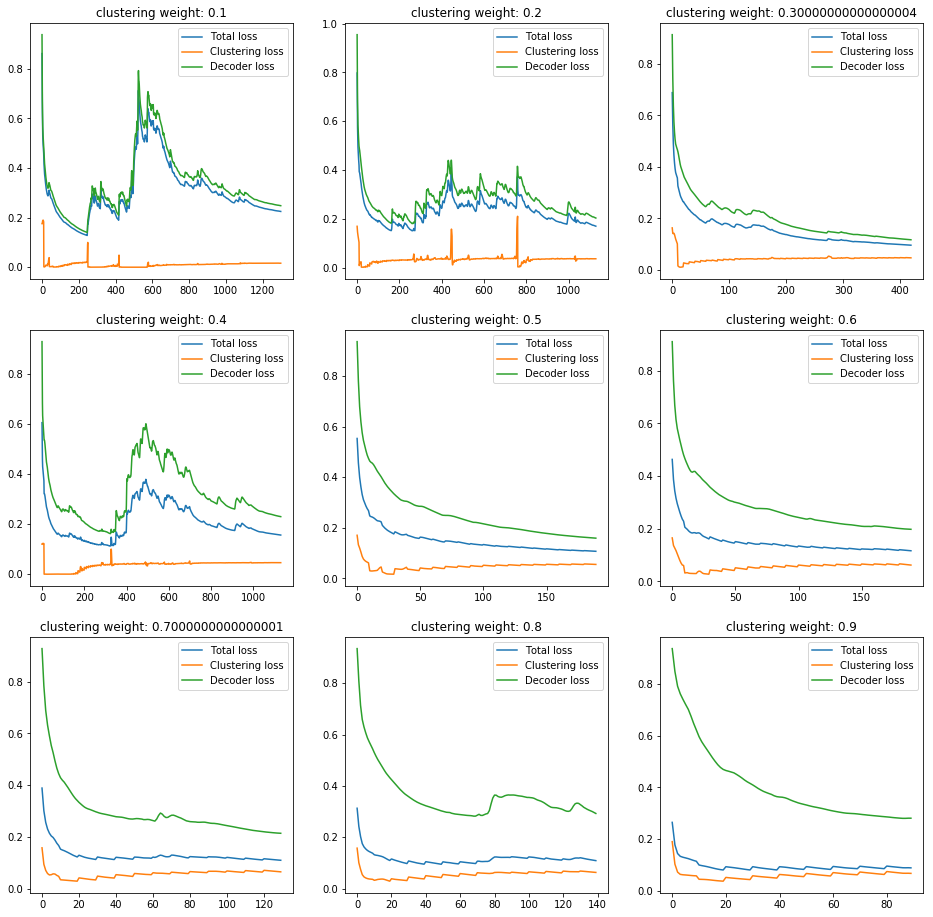

In [19]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

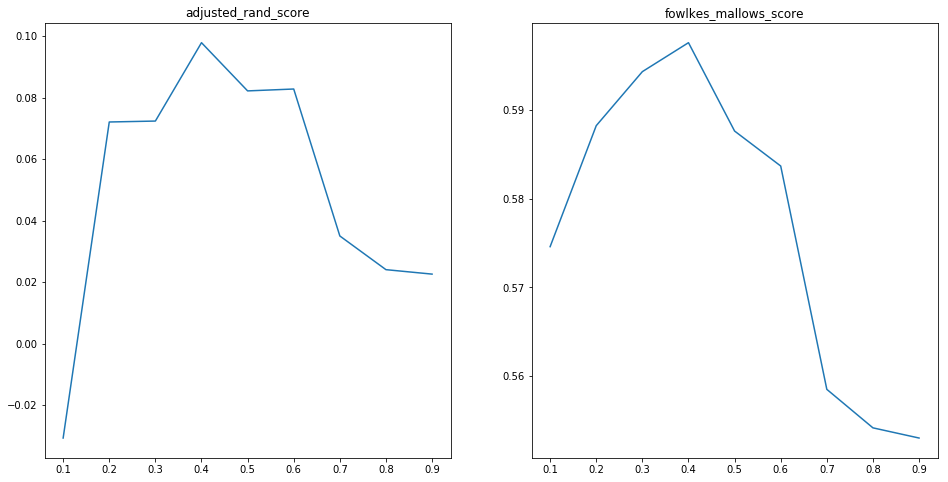

In [20]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')